# CIFAR图像识别—KNN
使用近邻识别方式，计算每个图片的最近邻，根据近邻判断图片的类型。

In [39]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 加载数据

In [2]:
# 加载数据
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    加载单批量的数据
    
    参数：
    cifar10_dataset_folder_path: 数据存储目录
    batch_id: 指定batch的编号
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [16]:
# 加载所有训练数据
cifar10_path = '/Users/Nelson/Desktop/Computer/courses/cifar-10-batches-py'
# 共有5个batch的训练数据
x_train, y_train = load_cfar10_batch(cifar10_path, 1)
for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

In [17]:
# 加载测试数据
with open(cifar10_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')
    x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = batch['labels']

# 图片概要

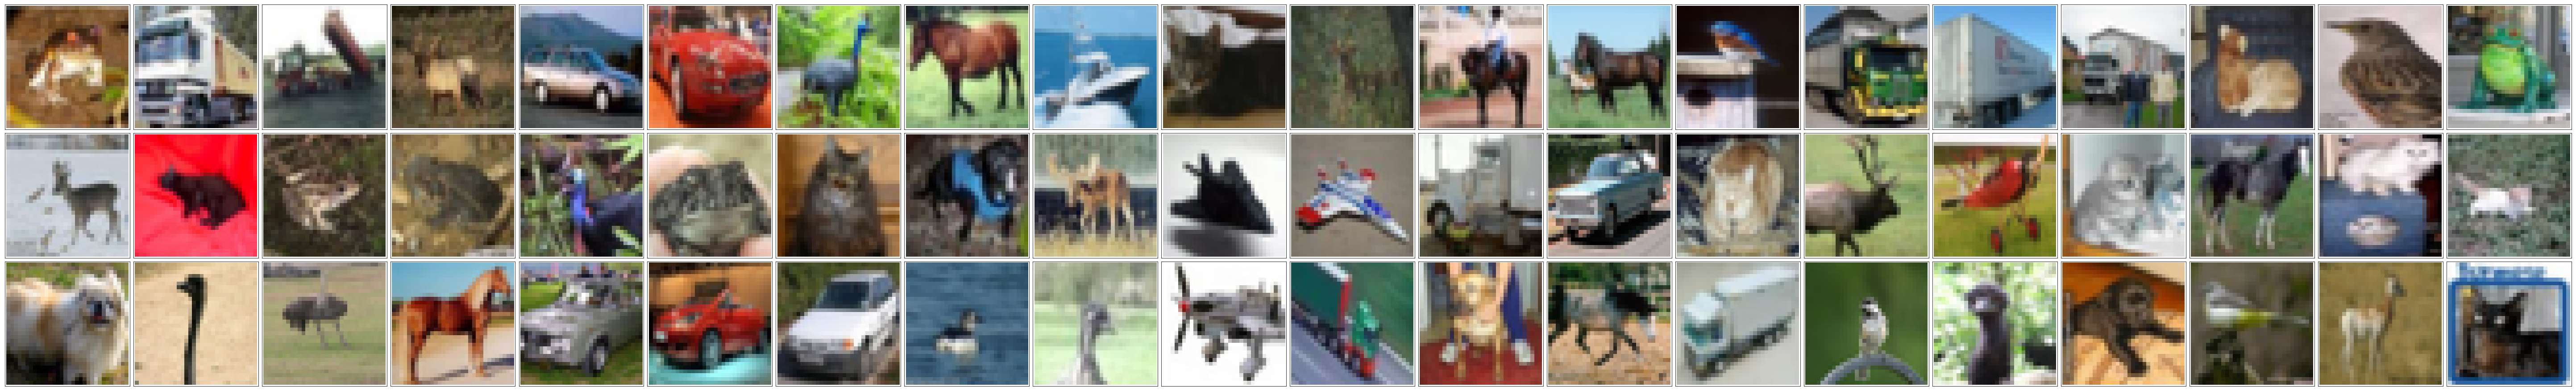

In [35]:
# 显示图片
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)


# 数据预处理

In [40]:
# 数据重塑
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

# 对像素进行缩放
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

x_train_rows = minmax.fit_transform(x_train_rows)
x_test_rows = minmax.fit_transform(x_test_rows)

# 模型构建

这里我采用了K = 1, 3, 5参数来看模型效果

In [51]:
# 进行knn计算
from sklearn.neighbors import KNeighborsClassifier

# 我们通过迭代来探索k值多少才合适
k = [1, 3, 5]
for i in k:
    model = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree', n_jobs=6)
    model.fit(x_train_rows, y_train)
    preds = model.predict(x_test_rows)
    print('k = %s, Accuracy = %f' % (i, np.mean(y_test==preds)))

k = 1, Accuracy = 0.353900
k = 3, Accuracy = 0.330300
k = 5, Accuracy = 0.339800


从KNN的分类准确率来看，是要比我们随机猜测类别提高了不少。我们随机猜测图片类别时，准确率大概是10%，KNN方式的图片分类可以将准确率提高到35%左右。当然有兴趣的小伙伴还可以去测试一下其他的K值，同时在上面的算法中，默认距离衡量方式是欧式距离，还可以尝试其他度量距离来进行建模。
虽然KNN在test数据集上表现有所提升，但是这个准确率还是太低了。除此之外，KNN有一个缺点，就是所有的计算时间都在predict阶段，当一个新的图来的时候，涉及到大量的距离计算，这就意味着一旦我们要拿它来进行图像识别，那可能要等非常久才能拿到结果，而且还不是那么的准。